In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sdsl as _sdsl


In [8]:
def sample_valid_poses(env, n_samples=1, max_tries=1000):
    """
    Sample valid poses inside the given environment.
    Returns a list of up to n_samples poses.
    """
    poses = []
    bb = env.bounding_box()
    tries = 0
    while len(poses) < n_samples and tries < max_tries:
        q = bb.sample()
        if env.is_inside(q):
            poses.append(q)
        tries += 1
    return poses


In [9]:

# Load Parquet file
file_path = "/Volumes/My Passport/ICRA2026-DataCollection/Lab446_Processed/merged_batch_0000.parquet"
df = pd.read_parquet(file_path)
print("Columns:", df.columns.tolist())
print("Number of frames:", len(df))


Columns: ['ts', 'tuple_idx', 'pcd_dev1_transformed', 'pcd_dev2_transformed', 'pcd_dev3_transformed', 'pcd_dev4_transformed', 'pcd_dev5_transformed']
Number of frames: 30036


In [10]:

import struct

def decode_pcd_array(b):
    if isinstance(b, bytes):
        f = np.frombuffer(b, dtype=np.float32)
        return f.reshape(-1, 2) if len(f) % 2 == 0 else np.empty((0, 2))
    return np.empty((0, 2))

devices = ['dev1', 'dev2', 'dev3', 'dev4', 'dev5']
for dev in devices:
    col = f"pcd_{dev}_transformed"
    df[col] = df[col].apply(decode_pcd_array)

print("Decoded transformed point cloud columns:")
print([f"pcd_{dev}_transformed" for dev in devices])


Decoded transformed point cloud columns:
['pcd_dev1_transformed', 'pcd_dev2_transformed', 'pcd_dev3_transformed', 'pcd_dev4_transformed', 'pcd_dev5_transformed']


In [11]:
# DEBUG: Show shape and bounds of merged PCD
if all_valid_points:
    all_points = np.vstack(all_valid_points)

    print("Combined point cloud shape:", all_points.shape)

    # Print axis range
    x_vals = all_points[:, 0]
    y_vals = all_points[:, 1]

    print("X Range (min, max):", x_vals.min(), x_vals.max())
    print("Y Range (min, max):", y_vals.min(), y_vals.max())
    print("X Percentiles (1%, 99%):", np.percentile(x_vals, [1, 99]))
    print("Y Percentiles (1%, 99%):", np.percentile(y_vals, [1, 99]))


NameError: name 'all_valid_points' is not defined

In [7]:
# Filter points to exclude outliers
x_low, x_high = np.percentile(all_points[:, 0], [1, 99])
y_low, y_high = np.percentile(all_points[:, 1], [1, 99])

filtered_points = all_points[
    (all_points[:, 0] >= x_low) & (all_points[:, 0] <= x_high) &
    (all_points[:, 1] >= y_low) & (all_points[:, 1] <= y_high)
]

print("Filtered points shape:", filtered_points.shape)


NameError: name 'all_points' is not defined

dev1: X(min,max)=-0.52,3.53 | Y(min,max)=-2.95,2.77 | count=548
dev2: X(min,max)=-0.45,3.89 | Y(min,max)=-2.89,2.64 | count=385
dev3: X(min,max)=-2.87,3.57 | Y(min,max)=-3.06,4.39 | count=555
dev4: X(min,max)=-0.80,3.70 | Y(min,max)=-3.49,2.59 | count=646
dev5: X(min,max)=-0.25,3.41 | Y(min,max)=-3.05,2.95 | count=550


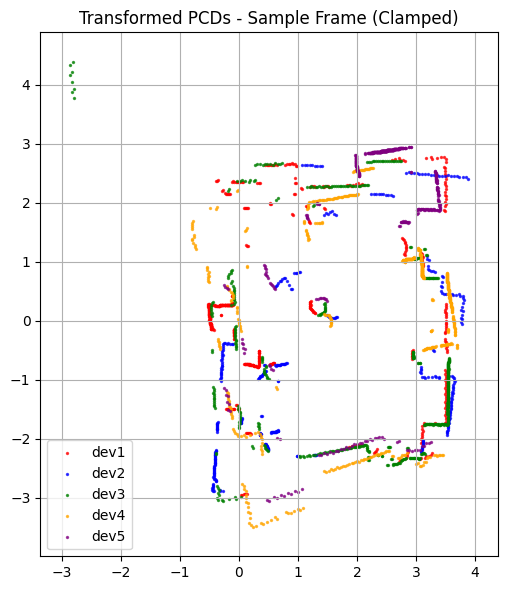

In [12]:
import matplotlib.pyplot as plt
import numpy as np

row = df.iloc[1000]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Transformed PCDs - Sample Frame (Clamped)")

colors = ['red', 'blue', 'green', 'orange', 'purple']
all_valid_points = []

for i, dev in enumerate(devices):
    col = f"pcd_{dev}_transformed"
    points = row[col]

    if isinstance(points, np.ndarray) and points.ndim == 2 and points.shape[1] == 2:
        valid = points[np.isfinite(points).all(axis=1)]

        # Clamp to ±100m to kill outliers
        mask = (np.abs(valid[:, 0]) < 100) & (np.abs(valid[:, 1]) < 100)
        final = valid[mask]

        if len(final) > 0:
            ax.scatter(final[:, 0], final[:, 1],
                       s=2, alpha=0.7, label=dev, c=colors[i % len(colors)])
            all_valid_points.append(final)

            # Debug stats
            print(f"{dev}: X(min,max)={final[:,0].min():.2f},{final[:,0].max():.2f} | "
                  f"Y(min,max)={final[:,1].min():.2f},{final[:,1].max():.2f} | count={len(final)}")
        else:
            print(f"⚠️ {dev}: no points after clamping")
    else:
        print(f"⚠️ {dev}: invalid type or shape")

if all_valid_points:
    all_points = np.vstack(all_valid_points)
    x_min, y_min = all_points.min(axis=0) - 0.5
    x_max, y_max = all_points.max(axis=0) + 0.5
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

ax.set_aspect("equal")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:

# Define odometry
L = 0.05
odometry = [
    _sdsl.R3xS2(
        L * np.cos(i * np.pi / 16), L * np.sin(i * np.pi / 16), 0,
        np.cos(i * np.pi / 16), np.sin(i * np.pi / 16), 0
    ) for i in range(32)
]


In [14]:
# --- Build merged environment with clamping ---
row = df.iloc[1000]  # or whichever frame you want

all_points = []
for dev in devices:
    col = f"pcd_{dev}_transformed"
    points = row[col]
    if isinstance(points, np.ndarray) and points.ndim == 2 and points.shape[1] == 2:
        valid = points[np.isfinite(points).all(axis=1)]
        # Clamp to remove outliers (±20m in X, ±5m in Y)
        mask = (np.abs(valid[:, 0]) < 20) & (np.abs(valid[:, 1]) < 5)
        clamped = valid[mask]
        if len(clamped) > 0:
            all_points.append(clamped)
            print(f"{dev}: kept {len(clamped)} points after clamping")
        else:
            print(f"{dev}: no points left after clamping")

if not all_points:
    raise ValueError("❌ No valid point clouds after clamping!")

# Merge into one array
merged_points_2d = np.vstack(all_points)
merged_points_3d = np.hstack([
    merged_points_2d,
    np.zeros((merged_points_2d.shape[0], 1))
])

# Create the environment for beam simulation
merged_env = _sdsl.Env_R3_PCD(merged_points_3d)

print("✅ Merged environment created with",
      merged_points_3d.shape[0], "points")


dev1: kept 548 points after clamping
dev2: kept 385 points after clamping
dev3: kept 555 points after clamping
dev4: kept 646 points after clamping
dev5: kept 550 points after clamping
✅ Merged environment created with 2684 points


In [15]:

MIN_VALID_BEAMS = 8
MAX_SAMPLE_ATTEMPTS = 50

for _ in range(MAX_SAMPLE_ATTEMPTS):
    poses = sample_valid_poses(merged_env, 1)
    if not poses:
        continue
    q0 = poses[0]
    ref_measurements = [merged_env.measure_distance(q0.act(g)) for g in odometry[:16]]
    valid_count = sum(d < 1e6 for d in ref_measurements)
    if valid_count >= MIN_VALID_BEAMS:
        print(f"✅ Valid pose with {valid_count}/16 beams")
        break
else:
    raise RuntimeError("❌ Could not find good pose")

ref_pose = q0
ref_measurements


✅ Valid pose with 11/16 beams


[1.7976931348623157e+308,
 1.7976931348623157e+308,
 1.7976931348623157e+308,
 1.7976931348623157e+308,
 1.7976931348623157e+308,
 0.007157316668983273,
 0.007931020653246532,
 0.006478468001895633,
 0.028415205054518573,
 0.16203655097145203,
 0.0811473773531555,
 0.06846825118322984,
 1.71056763474754,
 0.32867304061526487,
 0.07709601765158096,
 0.08625989687483072]

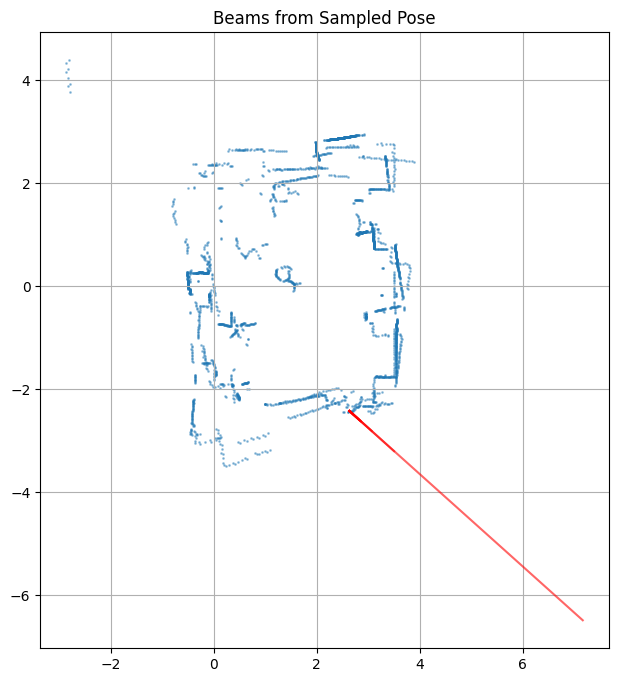

In [17]:

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Beams from Sampled Pose")

# Plot all merged points
ax.scatter(merged_points_2d[:, 0], merged_points_2d[:, 1], s=1, alpha=0.4)

# Plot beam rays
origin = np.array([q0.x(), q0.y()])
for i, g in enumerate(odometry[:16]):
    p = q0.act(g)
    d = ref_measurements[i]
    if d >= 1e6:
        continue
    target = np.array([p.x(), p.y()]) * d + origin
    ax.plot([origin[0], target[0]], [origin[1], target[1]], 'r-', alpha=0.6)

ax.set_aspect("equal")
plt.grid(True)
plt.show()


In [ ]:

comparison_results = []

for j in range(1001, 1010):  # next 9 frames
    row_j = df.iloc[j]
    merged = []
    for dev in devices:
        pts = row_j[f"pcd_{dev}_transformed"]
        if isinstance(pts, np.ndarray) and pts.ndim == 2 and pts.shape[1] == 2:
            valid = pts[np.isfinite(pts).all(axis=1)]
            if len(valid) > 0:
                merged.append(valid)

    if not merged:
        print(f"⚠️ Frame {j}: no valid PCDs")
        continue

    pts_2d = np.vstack(merged)
    pts_3d = np.hstack([pts_2d, np.zeros((pts_2d.shape[0], 1))])
    env = _sdsl.Env_R3_PCD(pts_3d)

    poses = sample_valid_poses(env, 100)
    for q in poses:
        meas = [env.measure_distance(q.act(g)) for g in odometry[:16]]
        diffs = [abs(m - r) for m, r in zip(meas, ref_measurements) if m < 1e6 and r < 1e6]
        if len(diffs) < MIN_VALID_BEAMS:
            continue
        comparison_results.append({
            "x": q.x(),
            "y": q.y(),
            "theta": q.r(),
            "avg_error": np.mean(diffs),
            "k_prime": sum(d < 1e6 for d in meas),
            "frame": j
        })

print(f"Comparison results collected: {len(comparison_results)}")


AttributeError: 'R3xS1' object has no attribute 'v1'